### VR Mini Project 2: Image Captioning 
Submitted By 
- Karanjit Saha (IMT2020003)
- Rishi Vakharia (IMT2020067)
- Monjoy Narayan Choudhury (IMT2020502) 


In [1]:
import pandas as pd 
import numpy as np 
import torch 
import torch.nn as nn
import torch.optim as optim
!pip install torchmetrics 
import torchmetrics 
import torchvision
import os 
from torchvision import transforms
from PIL import Image
import gc 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pickle
from torch.utils.data import Dataset
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch Version: ",torch.__version__,"\nRunning on device = ",device)

Torch Version:  2.0.0 
Running on device =  cuda


### Making The baseline 
- Encoder - CNN 
- Decoder - LSTM 

In [3]:
class EncoderCNN(nn.Module):
  def __init__(self,embedding_size):
    super(EncoderCNN,self).__init__()
    resnet = torchvision.models.resnet50(pretrained=True)
    for param in resnet.parameters():
        param.requires_grad_(False)
        
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.embed = nn.Linear(resnet.fc.in_features,embed_size)
  def forward(self,x):
    features = self.resnet(x)
    features = features.view(features.size(0),-1)
    return self.embed(features)

In [4]:
class DecoderLSTM(nn.Module):
  def __init__(self,embedding_size,hidden_size,vocab_size,num_layers):
    super(DecoderLSTM,self).__init__()
    self.embed = nn.Embedding(vocab_size,embedding_size)
    self.lstm = nn.LSTM(embedding_size,
                        hidden_size, 
                        num_layers=num_layers,
                        batch_first=True)
    self.linear = nn.Linear(hidden_size,vocab_size)
    self.dropout = nn.Dropout(0.3)

  def forward(self,features,captions):
    embeds = self.embed(captions[:,:-1])
    outputs = torch.cat((features.unsqueeze(1),embeds),dim=1)
    outputs,_ = self.lstm(outputs)
    outputs = self.linear(outputs)
    return outputs
  
  def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        batch_size = inputs.size(0)
        
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.linear(output)
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if predicted_word_idx.item() in vocab.itos.keys() and vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            inputs = self.embed(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx]  if idx in vocab.itos.keys() else "<UNK>" for idx in captions ]

In [5]:
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights

In [6]:
class EncoderCNNWithAttention(nn.Module):
    def __init__(self):
        super(EncoderCNNWithAttention, self).__init__()
        resnet = torchvision.models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    
        features = features.permute(0, 2, 3, 1)                         
        features = features.view(features.size(0), -1, features.size(-1)) 
        return features

In [7]:
class DecoderLSTMWithAttention(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        self.linear= nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.linear(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.linear(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if predicted_word_idx.item() in vocab.itos.keys() and vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx]  if idx in vocab.itos.keys() else "<UNK>" for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [8]:
class Baseline(nn.Module):
  def __init__(self,embedding_size,hidden_size,vocab_size,num_layers):
    super(Baseline,self).__init__()
    self.encoder = EncoderCNN(embedding_size)
    self.decoder = DecoderLSTM(embedding_size,hidden_size,vocab_size,num_layers)
  def forward(self,image,caption):
    features = self.encoder(image)
    outputs = self.decoder(features,caption)
    return outputs 
  

In [9]:
class BaselineWithAttention(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNNWithAttention()
        self.decoder = DecoderLSTMWithAttention(
            embed_size=embed_size,
            vocab_size = vocab_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

### Data Preparation and setup for train-eval-test 

#### Building DataLoader which takes in caption embeddings and image

Do not run the following cells now (use the processed pickle files)

In [10]:
# train_indices = {}
# test_indices = {}

# val_indices = {}
# with open('Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt', 'r') as file:
#   for line in file:
#     l = line.strip()
#     train_indices[l] = 1
# with open('Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt', 'r') as file:
#   for line in file:
#     l = line.strip()
#     test_indices[l] = 1 
# with open('Flickr8K/Flickr8k_text/Flickr_8k.valImages.txt', 'r') as file:
#   for line in file:
#     l = line.strip()
#     val_indices[l] = 1

In [11]:
# def create_captions_dataset(file_type,indices):
#     captions = []
#     with open('Flickr8K/Flickr8k_text/Flickr8k.token.txt', 'r') as file:
#         for line in file:
#             l = line.strip()
#             s = l.split("#")
#             t = s[1].split("\t")
#             if(s[0]) in indices:
#                 captions.append([s[0],t[1]])
#             else: continue 
#     df_caption = pd.DataFrame(captions)
#     df_caption.columns = ["filename","caption"]
#     df_caption.to_csv(file_type)


In [12]:
# create_captions_dataset("test_captions.csv",test_indices)

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [14]:
gc.collect()

0

In [15]:
import spacy
spacy_eng = spacy.load("en_core_web_sm")

### Writing Dataloader 

Helper Vocabulary class that adds token 

In [16]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold
        
    def __len__(self): 
        return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
                
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    

In [17]:
class FlickrDataset(Dataset):
    def __init__(self,root_dir,caption_file,transform=None,freq_threshold=4):
        # Get img, caption columns
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        #Get image and caption colum from the dataframe
        self.imgs = self.df["filename"]
        self.captions = self.df["caption"]
        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)
class Collate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self, pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs, targets

In [18]:
train_dataset = FlickrDataset("/kaggle/input/flickr-processed/Assignment 5/Flickr8K/Flicker8k_Images","/kaggle/input/flickr-processed/Assignment 5/train_captions.csv",transform)
val_dataset = FlickrDataset("/kaggle/input/flickr-processed/Assignment 5/Flickr8K/Flicker8k_Images","/kaggle/input/flickr-processed/Assignment 5/val_captions.csv",transform)
test_dataset = FlickrDataset("/kaggle/input/flickr-processed/Assignment 5/Flickr8K/Flicker8k_Images","/kaggle/input/flickr-processed/Assignment 5/test_captions.csv",transform)

In [19]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

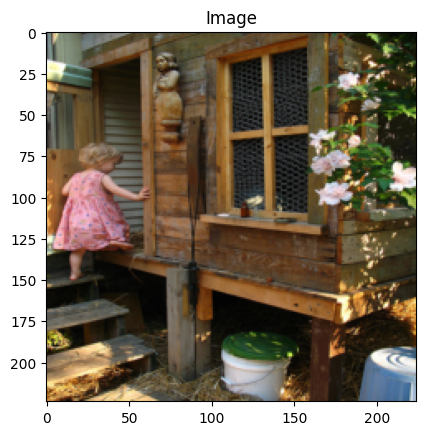

Token: tensor([  1,   4,   6, 331,  86,   4,  33,  81,   5,   2])
Sentence:
['<SOS>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<EOS>']


In [20]:
img, caps = train_dataset[1]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([train_dataset.vocab.itos[token] for token in caps.tolist()])

In [21]:
BATCH_SIZE = 16

#obtaining index number
pad_idx = train_dataset.vocab.stoi["<PAD>"]
pad_idx_val = val_dataset.vocab.stoi["<PAD>"]
pad_idx_test = test_dataset.vocab.stoi["<PAD>"]

train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=Collate(pad_idx=pad_idx,batch_first=True)
)

val_data_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=Collate(pad_idx=pad_idx_val,batch_first=True)
)

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=Collate(pad_idx=pad_idx_test,batch_first=True)
)

#### Defining Hyperparameters 

In [22]:
embed_size = 400
hidden_size = 512
vocab_size = len(train_dataset.vocab)
num_layers = 2
learning_rate = 1e-4
num_epochs = 30

#### Model Save helper 

In [23]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'num_layers':num_layers,
        'embed_size':embed_size,
        'vocab_size':len(train_dataset.vocab),
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'model_state.pth')

## Without Attention

#### Training Loop

Uncomment loop to train 

In [24]:
# from tqdm import trange


# model = Baseline(embedding_size=embed_size,hidden_size=hidden_size,vocab_size=vocab_size,num_layers=num_layers).to(device)
# criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# print_every = 1873
# for epoch in range(1,num_epochs+1):   
#     for idx, (image, captions) in tqdm(enumerate(iter(train_data_loader)),total=len(train_data_loader)):
#         image,captions = image.to(device),captions.to(device)

#         # Zero the gradients.
#         optimizer.zero_grad()

#         # Feed forward
#         outputs = model(image, captions)
#         # Calculate the batch loss.

#         loss = criterion( outputs.view(-1, vocab_size), captions.view(-1))
        
#         # Backward pass.
#         loss.backward()

#         # Update the parameters in the optimizer.
#         optimizer.step()

#         if(idx+1)%print_every==0:
#             print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
#             model.eval()
#             with torch.no_grad():
#                 dataiter = iter(val_data_loader)
#                 img,_ = next(dataiter)
#                 features = model.encoder(img[0:1].to(device))
#                 print(f"features shape - {features.shape}")
#                 caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=val_dataset.vocab)
#                 caption = ' '.join(caps)
#                 print(caption)
#                 show_image(img[0],title=caption)
                
#             model.train()
            
        
#     save_model(model,epoch)

### SECTION FOR LOADING PRETRAINED MODEL AND INFERENCE 

In [25]:
# checkpoint = torch.load("/kaggle/input/flickr-processed/model_state.pth")
# model.load_state_dict(checkpoint["state_dict"])

In [26]:
gc.collect()

3856

In [27]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

# model.eval()
# count = 0 
# with torch.no_grad():
#         dataiter = iter(val_data_loader)
#         img,true_caption = next(dataiter)
#         features = model.encoder(img[0:1].to(device))
#         print(f"features shape - {features.shape}")
#         caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=test_dataset.vocab)
#         ls = true_caption[0:1].tolist()[0]
#         truecaps = [test_dataset.vocab.itos[idx] for idx in ls]
#         bleu_score = sentence_bleu(truecaps, caps)
#         print("CAPTION PRED: ",caps," CAPTION_TRUE: ",truecaps)
#         print(bleu_score)
# #     caption = ' '.join(caps)
# #     print(caption)
# #     show_image(img[0],title=caption)


### BLEU SCORE COMPUTATION 

In [28]:
# model.eval()
# count = 0 
# bleu_score = 0 
# with torch.no_grad():
#     for idx, (images, captions) in tqdm(enumerate(iter(test_data_loader)),total=len(test_data_loader)):
#         for i in range(len(images)):
#             features = model.encoder(images[i].unsqueeze(0).to(device))
#             caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=test_dataset.vocab)
#             ls = true_caption[i].tolist()
#             truecaps = [test_dataset.vocab.itos[idx] for idx in ls]
#             bleu_score += sentence_bleu(truecaps, caps)
#             count+=1

# print("MEAN BLEU_SCORE FOR TEST DATA: ",bleu_score/count)

## With Attention 

### Train Loop

In [29]:
embed_size = 400
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
vocab_size = len(train_dataset.vocab)
num_layers = 2
learning_rate = 1e-4
num_epochs = 30

In [30]:
def save_model_attention(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(train_dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'model_state_attention.pth')

In [31]:
from tqdm.notebook import tqdm

loss_arr = []
intermediate_b_score = []

model = BaselineWithAttention(   
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim= attention_dim,
    encoder_dim= encoder_dim,
    decoder_dim=decoder_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# print_every = 1873
# # num_epochs+1
# for epoch in range(num_epochs):   
    
#     for idx, (image, captions) in tqdm(enumerate(iter(train_data_loader)),total=len(train_data_loader)):
#         image,captions = image.to(device),captions.to(device)

#         # Zero the gradients.
#         optimizer.zero_grad()

#         # Feed forward
#         outputs,attentions = model(image, captions)

#         # Calculate the batch loss.
#         targets = captions[:,1:]
#         loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
#         # Backward pass.
#         loss.backward()

#         # Update the parameters in the optimizer.
#         optimizer.step()

#         if (idx+1)%print_every == 0:
#             print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
#             loss_arr.append(loss.item())
            
#             #generate the caption
#             model.eval()
#             count = 0 
#             bleu_score = 0 
#             with torch.no_grad():
#                 for idx, (images, captions) in tqdm(enumerate(iter(val_data_loader)),total=len(val_data_loader)):
#                     for i in range(len(images)):
#                         features = model.encoder(images[i].unsqueeze(0).to(device))
#                         caps,_ = model.decoder.generate_caption(features,vocab=val_dataset.vocab)
#                         ls = captions[i].tolist()
#                         truecaps = [val_dataset.vocab.itos[idx] for idx in ls]
#                         bleu_score += sentence_bleu(truecaps, caps)
#                         count+=1
#             intermediate_b_score.append(bleu_score/count)
#             print("MEAN BLEU_SCORE FOR EVAL DATA: ",bleu_score/count)
#             model.train()
            
# dictionary = {
#     "loss_arr":loss_arr,
#     "intermediateb":intermediate_b_score
# }


# import pickle

# # Define a dictionary
# my_dict = dictionary

# # Open a file for writing in binary mode
# with open('statistics_attention.pickle', 'wb') as f:
#     # Use pickle.dump() to serialize and save the dictionary to the file
#     pickle.dump(my_dict, f)
# save_model_attention(model,epoch)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 303MB/s]


### Evaluation of BLEU SCORE 

In [32]:
checkpoint = torch.load("/kaggle/input/flickr-processed/model_state_attention.pth")
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [40]:
!pip install -U nltk 
from nltk.translate.meteor_score import meteor_score
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/co

In [44]:
model.eval()
count = 0 
bleu1=0
bleu2=0
bleu3=0
bleu4=0 
bleu_score = 0 
meteor_score = 0 
with torch.no_grad():
    for idx, (images, captions) in tqdm(enumerate(iter(test_data_loader)),total=len(test_data_loader)):
        for i in range(len(images)):
            features = model.encoder(images[i].unsqueeze(0).to(device))
            caps,_ = model.decoder.generate_caption(features,vocab=test_dataset.vocab)
            ls = captions[i].tolist()
            truecaps = [test_dataset.vocab.itos[idx] for idx in ls]
            bleu1 += sentence_bleu(truecaps, caps, weights=(1, 0, 0, 0))
            bleu2 += sentence_bleu(truecaps, caps, weights=(0.5, 0.5, 0, 0))
            bleu3 += sentence_bleu(truecaps, caps, weights=(0.33, 0.33, 0.33, 0))
            bleu4 += sentence_bleu(truecaps, caps, weights=(0.25, 0.25, 0.25, 0.25))
            meteor_score +=nltk.translate.meteor_score.meteor_score([truecaps],caps)
            count+=1
print("MEAN BLEU_SCORE-1 FOR TEST DATA: ",bleu1/count)
print("MEAN BLEU_SCORE-2 FOR TEST DATA: ",bleu2/count)
print("MEAN BLEU_SCORE-3 FOR TEST DATA: ",bleu3/count)
print("MEAN BLEU_SCORE-4 FOR TEST DATA: ",bleu4/count)
print("MEAN METEOR SCORE FOR TEST DATA",meteor_score/count)

  0%|          | 0/313 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


MEAN BLEU_SCORE-1 FOR TEST DATA:  0.10052347318827258
MEAN BLEU_SCORE-2 FOR TEST DATA:  0.30287565672346267
MEAN BLEU_SCORE-3 FOR TEST DATA:  0.4458540666509449
MEAN BLEU_SCORE-4 FOR TEST DATA:  0.5358972968816678
MEAN METEOR SCORE FOR TEST DATA 0.08658886804762081


### Attention Map 

In [45]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=test_dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

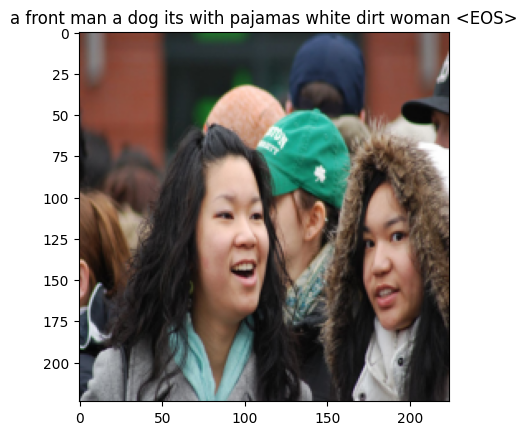

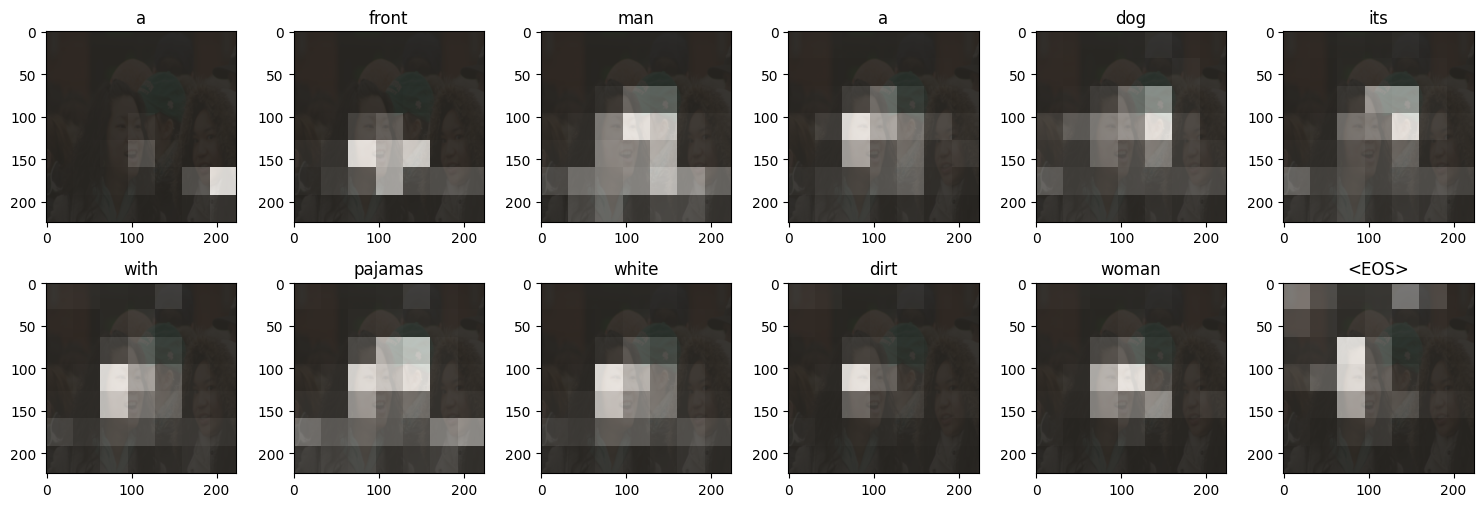

In [73]:
dataiter = iter(test_data_loader)
images,_ = next(dataiter)

img = images[1].detach().clone()
img1 = images[1].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)